# Project 4 : Anticipez les besoins en consommation de bâtiments

***

Ce notebook est le second notebook de ce projet. Le premier étant la collecte, le nettoyage et l'EDA et le Feature Engineering du jeu de données.

Ce notebook sera focalisé sur la modélisation, l'évaluation et l'optimisation des modèles de Machine Learning. Enfin, un choix final du modèle de prédiction, basé sur les différentes métriques étudiées, sera déterminé afin de pouvoir répondre au mieux à la problématique du projet.

Ce premier notebook sera l'étude de l'émission du CO2 et un second notebook sera rédigé pour l'étude de la consommation totale de l'énergie.

Comme pour le précédent notebook, ci-dessous sera affiché le sommaire :

***

#### Summary of the contents
* [Python's libraries](#Python-libraries)
* [Reading CSV's files and content overview](#Read-CSV-files-and-content-overview)
* [Features Selection](#Features-Selection)
* [Categorical features encoding](#Categorical-features-encoding)
    * [Using LabelEncoder() from sklearn](#Using-LabelEncoder()-from-sklearn)
    * [Using get_dummies() from pandas](#Using-get_dummies()-from-pandas)
* [GHG Emissions prediction](#GHG-Emissions-prediction)
    * [Splitting data](#Splitting-data)
    * [Scaling data](#Scaling-data)
    * [Building the Machine Learning model](#Building-the-Machine-Learning-model)
    * [Using DummyRegressor() for comparison](#Using-DummyRegressor()-for-comparison)
    * [Model optimization](#Model-optimization)
    * [Model Explainability with LIME](#Model-Explainability-with-LIME)

***

Et également les différentes fonctions/classes réalisées au cours du notebook seront répertoriées ci-dessous :

***

- <b><a href='#MultiColumnLabelEncoder'>MultiColumnLabelEncoder</a> </b>: calls LabelEncoder() function and applies it to every feature set as input of the class.
- <b><a href='#build_model'>build_model()</a> </b>: builds the ML model and calculates the associated metrics.
- <b><a href='#opt_model'>opt_model()</a> </b>: Optimizes the ML model and calculates the associated metrics.

# Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
import plotly.express as px

#import missingno as msno
#import random

# set the style of the plots
plt.style.use('seaborn-darkgrid')

# Copy/Paste if you need to display more columns in the output
#pd.options.display.max_columns = None

# Read CSV files and content overview

In [2]:
seattle_data = pd.read_csv('seattle_data.csv')
seattle_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,...,Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,7,...,3946027.0,1276453.0,False,Compliant,249.98,2.83,89,0.0,88434.0,7369.50
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,0659000220,7,...,3242851.0,5145082.0,False,Compliant,295.86,2.86,20,15.0,103566.0,9415.09
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,0659000475,7,...,49526664.0,1493800.0,False,Compliant,2089.28,2.19,47,21.0,956110.0,23319.76
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,0659000640,7,...,2768924.0,1811213.0,False,Compliant,286.43,4.67,90,0.0,61320.0,6132.00
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,0659000970,7,...,5368607.0,8803998.0,False,Compliant,505.01,2.88,36,35.0,175580.0,9754.44


# Features Selection

La selection des features est une étape primordiale avant la modélisation du modèle de Machine Learning. En effet, il faut pouvoir récupérer les informations importantes mais également cohérente avec la problématique. 

En se basant sur l'énoncé du projet qui dit que __notre prédiction se basera sur les <u>données structurelles</u> des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)__, il va donc falloir récupérer les features suivantes : `BuildingType`, `PrimaryPropertyType`, `Neighborhood`, `Latitude` et `Longitude`, `PropertyGFATotal` ou `LargestPropertyUseTypeGFA`, `LargestPropertyUseType`, `BuildingAge`, `NumberofBuildings`, `NumberofFloors` et `ENERGYSTARScore`. Ainsi que les deux variables cibles : `SiteEUI(kBtu/sf)`, `TotalGHGEmissions`.

In [3]:
len(seattle_data.NumberofBuildings.unique())

15

In [4]:
seattle_data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge',
       'GFABuilding(s)Pct', 'GFAperBuilding', 'GFAperFloor'],
      dtype='object')

In [5]:
corr = seattle_data.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,OSEBuildingID,DataYear,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor
OSEBuildingID,1.000000,nan,-0.180555,0.029341,0.105196,0.011883,0.047889,-0.283593,-0.147667,-0.229716,-0.120242,-0.108139,-0.051315,-0.010457,-0.051944,-0.090297,-0.012916,-0.104164,-0.074211,nan,-0.076510,0.083243,-0.011883,-0.200532,-0.297971,0.022308
DataYear,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CouncilDistrictCode,-0.180555,nan,1.000000,0.512255,-0.345700,-0.033093,-0.019748,0.308005,0.106702,0.192644,0.082903,0.067324,0.131836,0.067756,0.094523,0.045110,0.005608,0.071066,-0.012176,nan,0.008811,-0.011409,0.033093,0.218708,0.191178,-0.024781
Latitude,0.029341,nan,0.512255,1.000000,-0.081585,0.086482,0.021126,0.001490,0.005343,0.039460,-0.000304,0.005524,0.048837,0.089033,0.087193,0.008619,-0.005992,0.010809,0.000504,nan,-0.000978,0.039896,-0.086482,0.116476,-0.020485,0.011672
Longitude,0.105196,nan,-0.345700,-0.081585,1.000000,0.011794,0.023024,-0.018315,0.027216,-0.022636,0.031872,0.035108,-0.024680,-0.008907,-0.008672,0.040929,0.025430,0.030700,0.040600,nan,0.047195,0.010157,-0.011794,-0.057612,-0.001365,0.035517
YearBuilt,0.011883,nan,-0.033093,0.086482,0.011794,1.000000,-0.030318,0.105082,0.103567,0.290092,0.065058,0.068100,-0.047970,0.139891,0.174340,0.067705,-0.002251,0.078734,0.061211,nan,0.054414,0.001159,-1.000000,0.356076,0.215845,-0.014328
NumberofBuildings,0.047889,nan,-0.019748,0.021126,0.023024,-0.030318,1.000000,-0.022478,0.741581,-0.013675,0.778299,0.802634,-0.047307,0.029009,0.025388,0.715351,0.408926,0.760023,0.062914,nan,0.419741,0.028636,0.030318,-0.022836,-0.019553,0.915131
NumberofFloors,-0.283593,nan,0.308005,0.001490,-0.018315,0.105082,-0.022478,1.000000,0.442324,0.538783,0.382489,0.364936,0.149818,0.021949,0.064071,0.238236,0.100410,0.304877,0.037950,nan,0.140747,-0.052623,-0.105082,0.204008,0.729956,-0.036094
PropertyGFATotal,-0.147667,nan,0.106702,0.005343,0.027216,0.103567,0.741581,0.442324,1.000000,0.377277,0.990377,0.977699,0.141843,0.031077,0.050818,0.809450,0.455679,0.867813,0.153966,nan,0.527265,-0.010824,-0.103567,0.134668,0.610765,0.813096
PropertyGFAParking,-0.229716,nan,0.192644,0.039460,-0.022636,0.290092,-0.013675,0.538783,0.377277,1.000000,0.245476,0.274695,0.116157,0.046471,0.092231,0.142809,-0.000470,0.197786,0.026580,nan,0.055441,-0.099096,-0.290092,0.669772,0.627769,0.005959


In [6]:
seattle_ML = seattle_data.loc[:, ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
                                  'Neighborhood', 'Latitude', 'Longitude', 'BuildingAge', 'GFABuilding(s)Pct',
                                  'GFAperBuilding', 'GFAperFloor', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions',
                                  'ENERGYSTARScore']]
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,Hotel,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,Hotel,Hotel,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,Hotel,Hotel,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,Hotel,Hotel,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,Hotel,Hotel,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [7]:
seattle_ML = seattle_ML.loc[~seattle_ML.ENERGYSTARScore.isna()]

Une manière rapide de visualiser si certaines de nos features sont corrélées ou non est de générer la matrice des corrélations (afin d'éviter la multicolinéarité).

In [8]:
corr = seattle_ML.corr()
corr.style.background_gradient(cmap='coolwarm')

,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
Latitude,1.000000,-0.085438,-0.105815,0.125650,-0.029175,-0.050207,0.113399,-0.014723,0.048837
Longitude,-0.085438,1.000000,0.037558,-0.088283,-0.009673,0.046708,0.009784,0.055721,-0.024680
BuildingAge,-0.105815,0.037558,1.000000,-0.380499,-0.229075,-0.161998,-0.137459,-0.059979,0.047970
GFABuilding(s)Pct,0.125650,-0.088283,-0.380499,1.000000,0.259418,-0.021826,0.145315,-0.011479,0.022219
GFAperBuilding,-0.029175,-0.009673,-0.229075,0.259418,1.000000,0.233638,0.017658,0.198167,0.167332
GFAperFloor,-0.050207,0.046708,-0.161998,-0.021826,0.233638,1.000000,0.046629,0.241027,0.010013
SiteEUI(kBtu/sf),0.113399,0.009784,-0.137459,0.145315,0.017658,0.046629,1.000000,0.255854,-0.335584
TotalGHGEmissions,-0.014723,0.055721,-0.059979,-0.011479,0.198167,0.241027,0.255854,1.000000,-0.103341
ENERGYSTARScore,0.048837,-0.024680,0.047970,0.022219,0.167332,0.010013,-0.335584,-0.103341,1.000000


On remarque que grâce à notre Feature Engineering et aux variables créées à partir de certaines features corrélées, on a réussi à obtenir des features qui ne sont pas directement corrélées entre elles.

# Categorical features encoding

L'une des limitations majeure des modèles de Machine Learning est qu'ils ne comprennent et ne savent pas interpréter les features catégorielles. Il faut donc d'abord encoder numériquement toutes nos features catégorielles.

In [9]:
seattle_ML.shape

(1003, 13)

<a id='MultiColumnLabelEncoder'></a>

## Using LabelEncoder() from sklearn

On préférera `LabelEncoder()` pour les variables catégorielles dont les modalités sont beaucoup trop nombreuses (on évite le curse of dimentionality). Une version améliorée de cette fonction a été écrite pour pouvoir cette fonction sur plusieurs features simultanément.

In [10]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [11]:
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,Hotel,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,Hotel,Hotel,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,Hotel,Hotel,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,Hotel,Hotel,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,Hotel,Hotel,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [12]:
print('Nombre de modalités de chaque variable catégorielle avant encodage')
print('PrimaryPropertyType :', len(seattle_ML.PrimaryPropertyType.unique()))
print('LargestPropertyUseType :', len(seattle_ML.LargestPropertyUseType.unique()))

Nombre de modalités de chaque variable catégorielle avant encodage
PrimaryPropertyType : 16
LargestPropertyUseType : 21


In [13]:
# Use LabelEncoder on PrimaryPropertyType and LargestPropertyUseType
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

seattle_ML = MultiColumnLabelEncoder(columns = ['PrimaryPropertyType', 'LargestPropertyUseType']).fit_transform(seattle_ML)
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,2,6,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,2,6,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,2,6,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,2,6,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,2,6,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [14]:
print('Nombre de modalités de chaque variable catégorielle après encodage')
print('PrimaryPropertyType :', len(seattle_ML.PrimaryPropertyType.unique()))
print('LargestPropertyUseType :', len(seattle_ML.LargestPropertyUseType.unique()))

Nombre de modalités de chaque variable catégorielle après encodage
PrimaryPropertyType : 16
LargestPropertyUseType : 21


## Using get_dummies() from pandas

On peut utiliser la fonction `get_dummies()` de la librairie pandas lorsqu'une variable catégorielle n'a pas beaucoup de modalités. Ce qui est notre cas pour les variables `BuildingType` et `Neighborhood` qui ont respectivement 4 et 13 modalités.

In [15]:
# Use get_dummies on BuildingType and Neighborhood

seattle_ML = pd.get_dummies(seattle_ML, columns=['BuildingType', 'Neighborhood'])
seattle_ML.head()

,PrimaryPropertyType,LargestPropertyUseType,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
0,2,6,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,...,1,0,0,0,0,0,0,0,0,0
1,2,6,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,...,1,0,0,0,0,0,0,0,0,0
2,2,6,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,...,1,0,0,0,0,0,0,0,0,0
3,2,6,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,...,1,0,0,0,0,0,0,0,0,0
4,2,6,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,...,1,0,0,0,0,0,0,0,0,0


In [16]:
seattle_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1542
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PrimaryPropertyType                 1003 non-null   int64  
 1   LargestPropertyUseType              1003 non-null   int64  
 2   Latitude                            1003 non-null   float64
 3   Longitude                           1003 non-null   float64
 4   BuildingAge                         1003 non-null   int64  
 5   GFABuilding(s)Pct                   1003 non-null   float64
 6   GFAperBuilding                      1003 non-null   float64
 7   GFAperFloor                         1003 non-null   float64
 8   SiteEUI(kBtu/sf)                    1003 non-null   float64
 9   TotalGHGEmissions                   1003 non-null   float64
 10  ENERGYSTARScore                     1003 non-null   float64
 11  BuildingType_Campus                 1003 no

In [17]:
seattle_ML.corr().style.background_gradient(cmap='coolwarm')

,PrimaryPropertyType,LargestPropertyUseType,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
PrimaryPropertyType,1.000000,0.616414,-0.007131,-0.016658,0.157575,-0.255192,-0.347381,-0.079011,-0.075544,-0.179252,-0.079328,-0.076342,0.103136,0.002429,-0.107988,0.120374,0.002688,0.002407,-0.251336,-0.032214,0.144798,-0.059945,0.026128,0.050399,0.010562,0.059650,0.061798,0.082518
LargestPropertyUseType,0.616414,1.000000,0.173585,-0.025598,0.033399,-0.085280,-0.085645,-0.036070,0.057617,-0.112139,0.029723,-0.056910,0.095293,-0.018838,-0.089484,0.104983,0.002544,-0.010677,-0.100946,-0.020178,-0.185909,-0.023920,0.026257,0.069495,0.134467,0.095107,0.103904,0.134360
Latitude,-0.007131,0.173585,1.000000,-0.085438,-0.105815,0.125650,-0.029175,-0.050207,0.113399,-0.014723,0.048837,-0.002023,-0.012653,-0.043108,0.065075,0.221308,-0.036478,-0.271081,-0.101878,-0.014081,-0.567104,0.133571,0.126703,0.363960,0.313334,0.469034,-0.203726,-0.166828
Longitude,-0.016658,-0.025598,-0.085438,1.000000,0.037558,-0.088283,-0.009673,0.046708,0.009784,0.055721,-0.024680,0.091689,-0.046280,0.047293,-0.045398,-0.370359,0.211147,-0.172953,-0.067539,0.156172,0.163616,-0.070498,-0.402415,0.164409,0.398096,-0.101293,0.328885,-0.298725
BuildingAge,0.157575,0.033399,-0.105815,0.037558,1.000000,-0.380499,-0.229075,-0.161998,-0.137459,-0.059979,0.047970,-0.017287,0.066836,-0.071080,-0.022809,-0.025915,0.019884,-0.050311,0.248315,0.093781,0.043984,-0.169529,-0.150484,-0.066518,-0.038739,-0.059511,-0.054014,-0.003308
GFABuilding(s)Pct,-0.255192,-0.085280,0.125650,-0.088283,-0.380499,1.000000,0.259418,-0.021826,0.145315,-0.011479,0.022219,-0.035885,0.028641,0.027772,-0.045460,-0.020630,-0.072734,-0.079130,0.064922,0.034105,-0.227948,0.283771,0.135419,-0.037295,-0.016551,-0.072888,-0.035001,-0.055034
GFAperBuilding,-0.347381,-0.085645,-0.029175,-0.009673,-0.229075,0.259418,1.000000,0.233638,0.017658,0.198167,0.167332,0.004331,-0.054526,0.075046,0.009288,-0.073517,-0.058352,-0.042671,0.346331,-0.013581,-0.127103,0.025594,-0.050395,-0.030205,-0.079449,-0.077068,-0.047320,-0.048054
GFAperFloor,-0.079011,-0.036070,-0.050207,0.046708,-0.161998,-0.021826,0.233638,1.000000,0.046629,0.241027,0.010013,0.043516,-0.083489,-0.012335,0.112262,-0.017011,-0.029461,0.072352,-0.157473,0.010169,0.168089,-0.035224,-0.059961,0.057246,-0.010719,0.065671,0.005631,-0.009082
SiteEUI(kBtu/sf),-0.075544,0.057617,0.113399,0.009784,-0.137459,0.145315,0.017658,0.046629,1.000000,0.255854,-0.335584,0.016095,0.016217,0.002184,-0.041030,0.049832,-0.002092,0.001941,-0.014332,0.042226,-0.151138,0.026917,0.012581,0.007361,0.109372,0.003948,0.009281,0.012169
TotalGHGEmissions,-0.179252,-0.112139,-0.014723,0.055721,-0.059979,-0.011479,0.198167,0.241027,0.255854,1.000000,-0.103341,0.269543,-0.128751,-0.003225,-0.002956,-0.011278,0.006876,-0.022109,0.018478,0.134826,-0.029080,-0.027732,-0.040451,-0.019633,0.007266,-0.004844,-0.013829,-0.005733


# GHG Emissions prediction

Maintenant que toutes les features sont numériques, on va pouvoir procéder à la modélisation de nos modèles de Machine Learning.

A noter qu'il est généralement commun de réaliser des changements d'échelle, ou encore de réaliser une normalisation sur nos données d'entrée pour facilier l'apprentissage de notre modèle.

Le changement d'échelle (passer de l'échelle linéaire en logarithmique par exemple) permet d'élargir l'intervalle des valeurs lorsque les valeurs d'une features sont beaucoup trop proches les unes des autres.

In [18]:
seattle_ML = seattle_ML[~(seattle_ML['TotalGHGEmissions'] < 1)]

In [19]:
X_cols = seattle_ML.drop(['SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis=1).columns
y_col = 'TotalGHGEmissions'

X = seattle_ML.drop(['SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis=1).values
y = seattle_ML['TotalGHGEmissions'].values

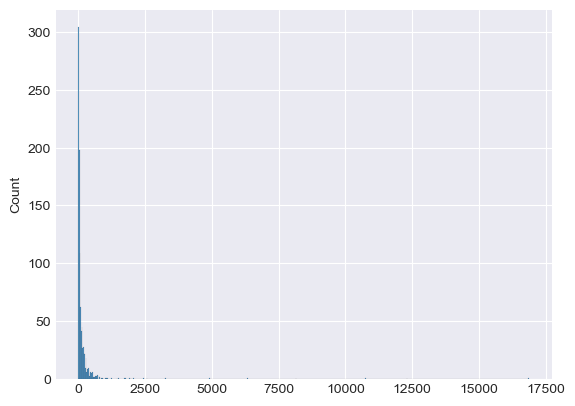

In [20]:
sns.histplot(data=seattle_ML, x=y)
plt.show()

In [21]:
y_log = np.log(y)

In [22]:
np.sort(y_log)

array([0.05826891, 0.11332869, 0.11332869, 0.13102826, 0.21511138,
       0.41210965, 0.43825493, 0.46373402, 0.47000363, 0.51282363,
       0.51879379, 0.53062825, 0.54812141, 0.61518564, 0.76546784,
       0.78390154, 0.7975072 , 0.85441533, 0.87962675, 0.9242589 ,
       0.97077892, 0.98954119, 1.02961942, 1.03673688, 1.03673688,
       1.05082162, 1.06815308, 1.11185752, 1.11185752, 1.11841492,
       1.178655  , 1.20597081, 1.22082992, 1.23837423, 1.25561604,
       1.28647403, 1.30019166, 1.31103188, 1.31372367, 1.31640823,
       1.32972401, 1.35840916, 1.37118072, 1.3912819 , 1.39871688,
       1.42310833, 1.43508453, 1.43983513, 1.46556754, 1.47017585,
       1.4929041 , 1.49962305, 1.521699  , 1.56024767, 1.59938758,
       1.60743591, 1.61342993, 1.62334082, 1.62334082, 1.6563215 ,
       1.6714733 , 1.68824909, 1.69193913, 1.69377906, 1.72097929,
       1.73342389, 1.73518912, 1.7681496 , 1.78170913, 1.78674693,
       1.79840401, 1.81807678, 1.82131827, 1.84054963, 1.84054

Les propriétés d'une distribution normale sont : La fonction de densité de probabilités de la loi normale a la forme d'une courbe en cloche symétrique. la moyenne et la médiane sont égales ; la courbe est centrée sur la moyenne.

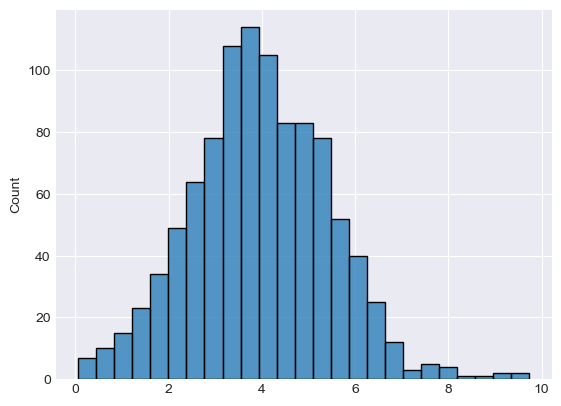

In [23]:
sns.histplot(data=seattle_ML, x=y_log)
plt.show()

In [24]:
y_log.mean()

3.966678305499861

On voit donc ici que la variable cible est asymétrique et beaucoup trop étroite (valeurs très proches entre elles) donc on va effectuer un changement d'échelle pour aider le modèle à apprendre.

## Splitting data

On procède toujours à la séparation des données en jeu d'entrainement et en jeu de test avant d'appliquer une quelconque transformation sur ceux-ci. En effet, on cherche à avoir un jeu de test pour la variable cible le plus inconnu possible et donc aucune opération ne doit être excécutée en amont sur le jeu de test de la variable cible.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3,
                                                    random_state=29)

## Scaling data

On normalise les features afin d'avoir des valeurs centrées et réduites.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [27]:
print(np.mean(X_test), np.std(X_test))
print(np.mean(X_test_scaled), np.std(X_test_scaled))

6599.996184509192 52664.51820622642
0.005367345269229152 0.9971567380448555


<a id='build_model'></a>

## Building the Machine Learning model

La partie modélisation des modèles de ML se fait ici, toute la phase d'instantiation des modèles, d'entrainement et de prédiction se fait dans la fonction `build_model()`. Cette fonction retournera un DataFrame contenant toutes les informations des modèles crées ainsi que les métriques associées.

La fonction affiche également les coefficients de la régression linéaire ou bien les features importances (pour les modèles ensemblistes) qui déterminent la contribution globale des features sur le modèle généré.

In [28]:
# Création du DF qui résumera toutes les informations des différents modèles et valeurs de métriques
res = pd.DataFrame()

In [29]:
# Fonction qui créé un modèle de ML

def build_model(model, X_train_scaled, X_test_scaled, y_train, y_test, df):
    '''
    Builds the ML model and calculates the associated metrics. It instantiates, fits on a training set
    and predicts on a test set and then retrieve the R2 of the train set, the R2 of the test set and
    the RMSE
    
    Parameters:
    model (Dictionary): a dict of all the ML models
    X_train_scaled (Array): scaled (or not) features training set
    X_test_scaled (Array): scaled (or not) features test set
    y_train (Array): target training set
    y_test (Array): target test set
    df (DataFrame): A DataFrame to store the metrics
    
    Returns:
    df (DataFrame): a DataFrame that has stored metrics
    '''
    
    i=0
    
    for k, model in models.items():
        #set a timer to calculate the computing time
        start_time = time.time()
        
        #print('Model used:', model)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        #end of timer
        end_time = time.time() - start_time
        print('Time elapsed for building the', k, 'model:', end_time, 'seconds.')
        
        # R-squared or coef de détermination du training set
        r_train = model.score(X_train_scaled, y_train)
        #print('R-square of the training set:', r_train)
        
        # R-squared or coef de détermination du test set
        r_test = model.score(X_test_scaled, y_test)
        #print('R-square of the test set:', r_test)
        
        # RMSE of the model used
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        #print('RMSE:', rmse)
        
        # Print the coefficients of the model
        if k == 'Random Forest Regressor' or k == 'Gradient Boosting Regressor':
            coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.feature_importances_})
        else:
            coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.coef_})
            
        # print(coefficients)
        print('Coefficients du modèle', k)
        sns.barplot(data=coefficients, x='Coefficients', y='Features')
        plt.show()
        
        df.loc[i, 'Modele'] = k
        df.loc[i, 'R-squared (training set) [%]'] = r_train * 100
        df.loc[i, 'R-squared (test set) [%]'] = r_test * 100
        df.loc[i, 'RMSE [CO2e/MBtu]'] = rmse
        df.loc[i, 'Computing time [s]'] = end_time 
        
        i=i+1
    
    return df
    

Time elapsed for building the Linear Regression model: 0.009114742279052734 seconds.
Coefficients du modèle Linear Regression


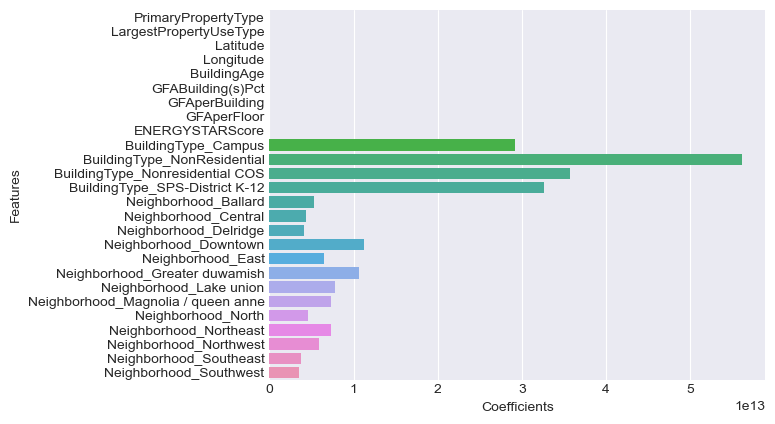

Time elapsed for building the Ridge model: 0.004540920257568359 seconds.
Coefficients du modèle Ridge


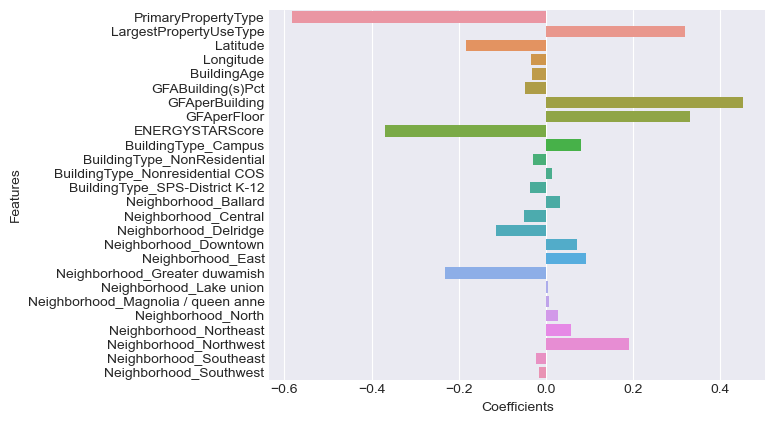

Time elapsed for building the Lasso model: 0.002794981002807617 seconds.
Coefficients du modèle Lasso


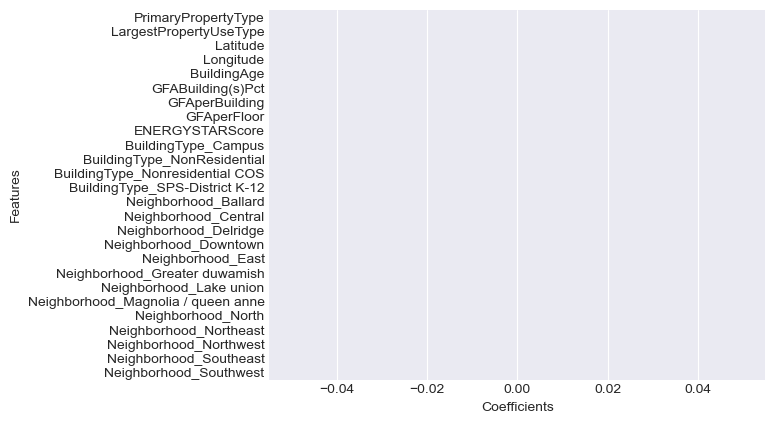

Time elapsed for building the Random Forest Regressor model: 0.2830491065979004 seconds.
Coefficients du modèle Random Forest Regressor


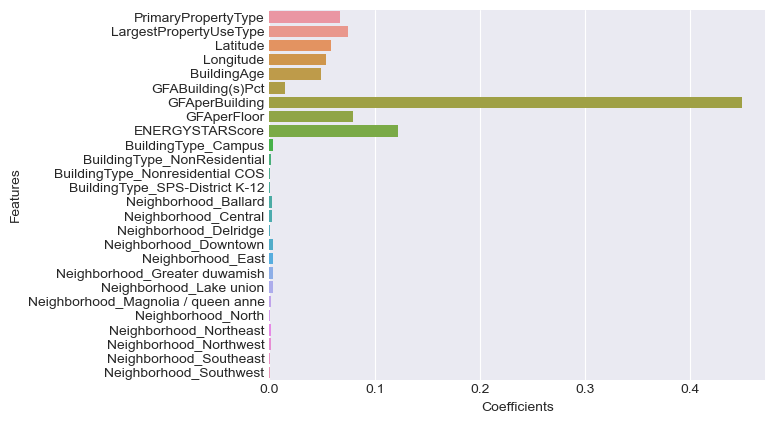

Time elapsed for building the Gradient Boosting Regressor model: 0.09891200065612793 seconds.
Coefficients du modèle Gradient Boosting Regressor


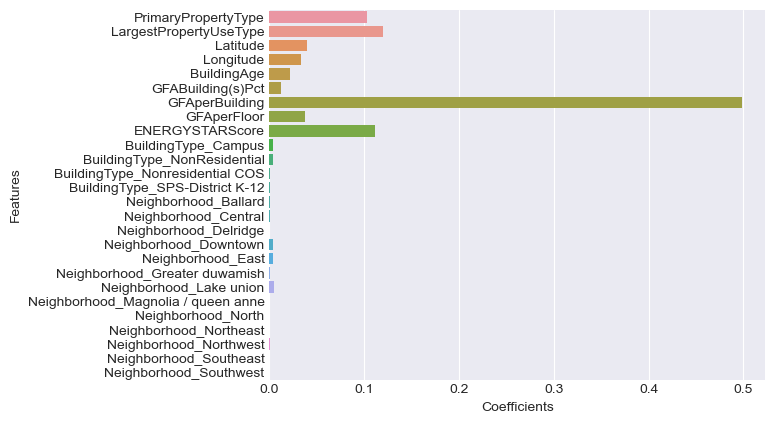

,Modele,R-squared (training set) [%],R-squared (test set) [%],RMSE [CO2e/MBtu],Computing time [s]
0,Linear Regression,46.761543,38.074341,1.203486,0.009115
1,Ridge,47.029959,38.749616,1.196907,0.004541
2,Lasso,0.000000,-0.091490,1.530046,0.002795
3,Random Forest Regressor,93.660630,54.277240,1.034123,0.283049
4,Gradient Boosting Regressor,81.341521,60.943783,0.955765,0.098912


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time

from sklearn.metrics import mean_squared_error

seed=29

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(random_state=seed),
          "Lasso": Lasso(random_state=seed),
          "Random Forest Regressor": RandomForestRegressor(random_state=seed),
          "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed)}

res = build_model(models, X_train_scaled, X_test_scaled, y_train, y_test, res)
res

En gardant la valeur par défaut de l'algo `Lasso()`, on remarque que tous les coefficients sont ramenés à 0. Avant d'optimiser les hyperparamètres, on veut s'assurer que l'algo a correctement été implémenté et pour cela, on va changer la valeur par defaut d'alpha en la diminuant.

R-square of the training set: 0.467918811810924
R-square of the test set: 0.38849589671027385
RMSE: 1.195929490056342
-----
[-0.55979425  0.29853759 -0.01110571 -0.         -0.01710664 -0.02453133
  0.45284596  0.32028278 -0.35992869  0.08764843 -0.          0.01851369
 -0.00931708  0.         -0.03898188 -0.05223777  0.07760541  0.07859874
 -0.14692355 -0.00772048 -0.         -0.02496843  0.          0.11203486
  0.          0.00963833]
Coefficients du modèle: Lasso(alpha=0.01)


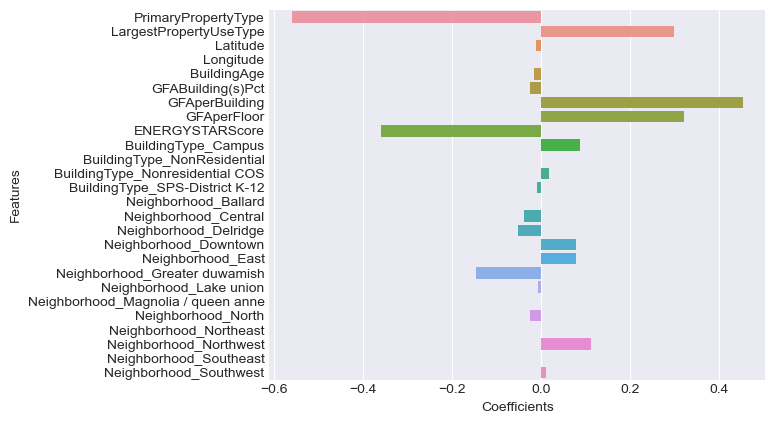

In [31]:
# On fit le modèle Lasso avec un autre alpha pour vérifier l'implémentation

model = Lasso(alpha=0.01)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
        
# R-squared or coef de détermination du training set
r_train = model.score(X_train_scaled, y_train)
print('R-square of the training set:', r_train)
        
# R-squared or coef de détermination du test set
r_test = model.score(X_test_scaled, y_test)
print('R-square of the test set:', r_test)
        
# RMSE of the model used
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

print('-----')
print(model.coef_)

# Print the coefficients of the model
coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.coef_})
            
# print(coefficients)
print('Coefficients du modèle:', model)
sns.barplot(data=coefficients, x='Coefficients', y='Features')
plt.show()

En diminuant le $\alpha$ de 1 à 0.01, on voit qu'il y a des changements sur les coefficients qui se sont opérés. Ça permet de voir l'évolution du `Lasso()` lorsqu'on fait varier son hyperparamètre $\alpha$. Un chapitre pour l'optimisation du modèle avec les hyperparamètres y sera dédié dans la suite du notebook.

## Using DummyRegressor() for comparison

Afin d'avoir une meilleure compréhension des valeurs des métriques, il faut avoir un modèle de comparaison pour s'assurer que la valeur des métriques retournée par nos modèles ait un réel sens.

Pour cela, on va faire appel à la fonction DummyRegressor(). Il se base sur une statistique (médiane, moyenne, constante,...) et réalise ses prédictions en fonction de la statistique choisie. Pour notre cas, j'ai laissé la statistique par défaut qui est la moyenne. La fonction va donc toujours prédire la moyenne du jeu d'entrainement.

In [32]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

dr.fit(X_train_scaled, y_train)
y_pred = dr.predict(X_test_scaled)
        
r_train = dr.score(X_train_scaled, y_train)
print('R-square of the training set:', r_train)
        
r_test = dr.score(X_test_scaled, y_test)
print('R-square of the test set:', r_test)
        
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

R-square of the training set: 0.0
R-square of the test set: -0.0009149043637581844
RMSE: 1.5300459212943407


On remarque que la valeur de nos métriques a tendance à toujours être supérieure aux valeurs calculées par notre modèle de comparaison, ce qui est un bon signe sur la cohérence de nos modèles.

<a id='opt_model'></a>

## Model optimization

L'optimisation des modèles est une étape très importante lors de la modélisation de notre modèle. En effet, il permet de déterminer les paramètres les plus adéquats pour obtenir de bons résultats. L'optimisation des hyperparamètres de notre modèle est donc crucial et doit être considérée et étudiée d'une manière importante.

Pour cette étape d'optimisation, il est important de noter que le modèle peut facilement sur-apprendre sur le jeu d'entrainement et donc avoir un haut biais et une fiable variance.

Une manière de contrer ce sur-apprentissage est d'utiliser la technique de Cross-Validation, sur Python un Object appelé KFold peut être appelé. Le principe est la division des données d’entraînements en plusieurs groupes. L’idée est ensuite d’entraîner le modèle sur tous les groupes sauf un. Si on a k groupes, on entraînera le modèle k fois avec à chaque fois un nouveau groupe de test. Chaque groupe renverra un score/une performance et la performance finale sera la moyenne des performances réalisées par nos groupes. Cela permet de rendre plus robuste l'entrainement de notre modèle.

In [33]:
# Fonction d'optimisation des modèles

def opt_model(model, hp_candidates, kfold, n_iter, scoring, 
              X_train_scaled, X_test_scaled, y_train, y_test, df):
    '''
    Optimizes the ML model and calculates the associated metrics. It optimizes the hyperparameters, fits
    on a training set and predicts on a test set and then retrieve all the necessary metrics.
    
    Parameters:
    model (Dictionary): a dict of all the ML models
    hp_candidates (2D Dictionary): a 2d dict with all the hyperparameters and the tested values
    kfold (Object): a KFold object
    n_iter (int): number of iteration for the RandomizedSearchCV() function
    scoring (string): the score we want to use for the RandomizedSearchCV() function
    X_train_scaled (Array): scaled (or not) features training set
    X_test_scaled (Array): scaled (or not) features test set
    y_train (Array): target training set
    y_test (Array): target test set
    df (DataFrame): A DataFrame to store the metrics
    
    Returns:
    df (DataFrame): a DataFrame that has stored metrics
    list_models (list): a list that contains all the models fitted
    best_estimator (list): a list that contains the best estimator for each model
    '''
    
    list_models = []
    best_estimator = []
    
    i=0
    
    for k, model in models.items():
        
        #set a timer to calculate the computing time
        start_time = time.time()
        
        grid = RandomizedSearchCV(model, param_distributions=hp_candidates[k], cv=kfold,
                                  n_iter=n_iter, scoring=scoring, random_state=seed, n_jobs = -1)
        grid.fit(X_train_scaled, y_train)
        
        #end of timer
        end_time = time.time() - start_time
        print('Time elapsed for building the', k, 'model:', end_time, 'seconds.')
        
        list_models.append(grid)
        best_estimator.append(grid.best_estimator_)
        
        model = grid.best_estimator_
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        
        # R-squared or coef de détermination du training set
        r_train = model.score(X_train_scaled, y_train)
        #print('R-square of the training set:', r_train)
        
        # R-squared or coef de détermination du test set
        r_test = model.score(X_test_scaled, y_test)
        #print('R-square of the test set:', r_test)
        
        # RMSE of the model used
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        #print('RMSE:', rmse)
        
        df.loc[df['Modele'] == k, 'Opti. R-squared (training set) [%]'] = r_train * 100
        df.loc[df['Modele'] == k, 'Opti. R-squared (test set) [%]'] = r_test * 100
        df.loc[df['Modele'] == k, 'Opti. RMSE [CO2e/MBtu]'] = rmse
        df.loc[df['Modele'] == k, 'Opti. computing time [s]'] = end_time
        
        i=i+1
        
    #print(best_estimator)
    
    return df, list_models, best_estimator
    

In [34]:
res["Opti. R-squared (training set) [%]"] = np.nan
res["Opti. R-squared (test set) [%]"] = np.nan
res["Opti. RMSE [CO2e/MBtu]"] = np.nan
res["Opti. computing time [s]"] = np.nan

In [35]:
from sklearn.model_selection import KFold, RandomizedSearchCV

# Create 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
n_alphas = 100
n_iter = 100
scoring = 'r2'
n = 50

# Number of alphas in regularization
alphas = np.linspace(0.001, 100, n_alphas)

# Number of trees
n_estimators = [int(x) for x in np.linspace(50, 1500, n)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 6, 8)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Learning rate for the boosting
learning_rate = np.linspace(0.05, 0.2, n)

models = {"Ridge": Ridge(random_state=seed), "Lasso": Lasso(random_state=seed),
          "Random Forest Regressor": RandomForestRegressor(random_state=seed),
          "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed)}

# hyperparamètres à optimiser pour les modèles Ridge et Lasso
hp_candidates_lr = [{'alpha': alphas}]
# hyperparamètres à optimiser pour le modèle Random Forest
hp_candidates_rf = [{'n_estimators': n_estimators, 'max_depth': max_depth, 'bootstrap': bootstrap}]
# hyperparamètres à optimiser pour le modèle Gradient Boosting
hp_candidates_gb = [{'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}]
# 2D dict avec les dicts des hyperparamètres de chaque modèle
hp_candidates = {"Ridge": hp_candidates_lr, "Lasso": hp_candidates_lr,
                 "Random Forest Regressor": hp_candidates_rf,
                 "Gradient Boosting Regressor": hp_candidates_gb}

res, list_models, best_estimators = opt_model(models, hp_candidates, kfold, n_iter, scoring,
                                              X_train_scaled, X_test_scaled, y_train, y_test, res)


Time elapsed for building the Ridge model: 1.8573949337005615 seconds.
Time elapsed for building the Lasso model: 0.11091780662536621 seconds.
Time elapsed for building the Random Forest Regressor model: 38.503072023391724 seconds.
Time elapsed for building the Gradient Boosting Regressor model: 24.447860956192017 seconds.


In [36]:
display(res)

,Modele,R-squared (training set) [%],R-squared (test set) [%],RMSE [CO2e/MBtu],Computing time [s],Opti. R-squared (training set) [%],Opti. R-squared (test set) [%],Opti. RMSE [CO2e/MBtu],Opti. computing time [s]
0,Linear Regression,46.761543,38.074341,1.203486,0.009115,NaN,NaN,NaN,NaN
1,Ridge,47.029959,38.749616,1.196907,0.004541,46.706640,38.438584,1.199942,1.857395
2,Lasso,0.000000,-0.091490,1.530046,0.002795,47.022697,38.767262,1.196734,0.110918
3,Random Forest Regressor,93.660630,54.277240,1.034123,0.283049,93.915541,55.657195,1.018398,38.503072
4,Gradient Boosting Regressor,81.341521,60.943783,0.955765,0.098912,83.340252,60.928895,0.955947,24.447861


NB : L'attribut `best_score_` contient le score de validation moyen sur tous les splits de la meilleure configuration de l'hyperparamètre.

D'après l'optimisation du modèle, on voit que le modèle ayant le meilleur score R2 et le RMSE le plus faible est le `Gradient Boosting Regressor`. On va donc pouvoir utiliser les paramètres optimisés pour ce modèle dans la suite de notre projet.

In [37]:
gb = list_models[3].best_estimator_
gb.fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)

In [38]:
print('R-squared train set:', gb.score(X_train_scaled, y_train))
print('R-squared test set:', gb.score(X_test_scaled, y_test))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

R-squared train set: 0.833402522621493
R-squared test set: 0.6092889508323172
RMSE: 0.9559468223680343


Maintenant avoir choisi notre modèle et ayant eu un avant-goût de l'interprétabilité du modèle d'un point de vue globale. On va s'intéresser à l'interprétation du modèle d'un point de vue locale.

## Model Explainability with LIME

Une importance particulière doit être portée sur l'interprétabilité du modèle. En effet, les métriques traditionnelles des modèles de Machine Learning ne permettent pas aux usagers de ces modèles une confiance absolue dans la performance et la fiabilité des modèles.

Un exemple évident est un modèle d'apprentissage qui donne une précision supérieure à 95% mais qui ne parvient pas à reconnaître certaines modalités de l'ensemble de données en raison de l'utilisation de caractéristiques non pertinentes lors de la prédiction et peut en résulter des problèmes beaucoup plus grave (comme pour la détection de fraudes bancaires).

En général, la complexité du modèle et son interprétabilité ont une relation inverse. Plus la complexité du modèle est élevé, moins il sera facile d'interpréter le modèle. Les modèles complexes comme le XGBoost ou les Forêts Aléatoires ont une précision elevée mais sont relativement compliqués à interpréter comparés aux modèles plus simples (Linear Regression, Logistic Regression,...) qui ont une précision moins elevée mais qui sont facilement interprétable. Pour cause, les modèles complexes comme les réseaux de neurones ou les Forêts Aléatoires sont considérés comme des __boîtes noires__ tandis que les modèles plus simples sont appelés des __boîtes transparentes__.

Pour pouvoir interpréter le modèle, plusieurs techniques s'offrent à nous : LIME, SHAP, Features Importance, eli5, captum, interpret-ml... Mais on va plus s'attarder sur la technique du LIME.

L'algorithme LIME (Local Interpretable Model-Agnostic Explanations) prend en entrée n'importe quel modèle (il peut être appliqué à n'importe quel modèle) et génère des explications sur les contributions des features à la réalisation d'une prédiction sur __une observation__ en ajustant les valeurs des features et observe l'impact qui en résulte sur la sortie, il nous permet de générer une explication pour une observation. 

LIME permet d'interpréter de manière locale le modèle. Il suppose que le modèle 'complexe' est un modèle de boîte noire, ce qui signifie qu'il ne connaît pas le fonctionnement interne du modèle et génère une explication basée sur cette hypothèse. Les résultats de l'interprétation d'une observation peuvent être différents d'une autre.

Voici en quelques mots, le fonctionnement de l'algorithme LIME :

- On fournit à l'algorithme une observation unique et il génère un faux ensemble de données à partir de celui-ci en modifiant légèrement les valeurs des features de l'observation unique.
- Il calcule ensuite les mesures de distance (ou de similarité) entre les fausses données permutées et l'observation originale. Cela permet de comprendre le degré de similarité entre les fausses données permutées et la donnée originale. Les méthodes de la librairie LIME nous offrent la possibilité d'essayer différentes mesures.
- Il effectue ensuite une prédiction sur ces nouvelles données fictives permutées à l'aide de notre modèle complexe d'origine.
- Il sélectionne ensuite les features qui décrivent au mieux les performances de notre modèle complexe sur les fausses données permutées. La librairie LIME nous permet d'indiquer le nombre de caractéristiques à sélectionner.
- Il ajuste ensuite un modèle simple (comme une régression linéaire ou logistique) sur la combinaison des données fictives permutées avec les caractéristiques m sélectionnées et les scores de similarité calculés dans les étapes précédentes. La librairie LIME nous permet de fournir un modèle simple que nous voulons/pouvons utiliser/comprendre. En général, il s'agit d'une régression linéaire ou d'une régression logistique, mais il est possible d'utiliser d'autres modèles.
- LIME utilise ensuite les poids dérivés de ce modèle simple pour chaque feature afin d'expliquer comment chaque feature a contribué à faire une prédiction pour cet échantillon lorsqu'il a été prédit à l'aide d'un modèle complexe original.

En fait, il génère de fausses données en utilisant nos données d'entrée, entraîne un modèle ML simple qui a les mêmes performances que notre modèle complexe de boîte noire, et utilise les poids de ce modèle pour décrire l'importance des features.

In [39]:
import lime.lime_tabular

# create the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X_cols,
                                                   mode='regression')

In [40]:
# Choose the 20th instance and use it to predict the results
i = 20
exp = explainer.explain_instance(X_test_scaled[i], gb.predict, num_features=10)
exp.show_in_notebook(show_all=False)

print('Liste des features avec leur contribution à la valeur de prédiction :')
display(exp.as_list())

Liste des features avec leur contribution à la valeur de prédiction :


[('ENERGYSTARScore > 0.84', -0.4916201052583607),
 ('BuildingType_Nonresidential COS <= -0.09', -0.3209299966494708),
 ('-0.24 < LargestPropertyUseType <= -0.00', -0.30101975939191633),
 ('GFABuilding(s)Pct <= -0.52', 0.23490740848566236),
 ('BuildingType_Campus <= -0.08', -0.2178168350320633),
 ('BuildingType_SPS-District K-12 <= -0.08', 0.20251371886166902),
 ('-0.13 < BuildingAge <= 0.80', 0.19150239965294252),
 ('0.30 < PrimaryPropertyType <= 0.72', -0.1459662970744935),
 ('Neighborhood_Northwest <= -0.24', -0.13621002693300951),
 ('Neighborhood_Lake union <= -0.33', 0.13150628004091938)]

Pour la première instance (premier immeuble), la valeur prédite par notre modèle est de 2.87 CO2e/MBtu (émission totale de CO2 produite par l'immeuble). On remarque que la contribution des features `GFAperBuilding`, `ENERGYSTARScore` et `BuildingType_SPS-District K-12` sont les plus importants dans la décision de la valeur prédite de 2.87. La feature `GFAperBuilding` a une influence négative sur la prédiction de l'émission de CO2 tandis que les features `ENERGYSTARScore` et `BuildingType_SPS-District K-12` ont une influence positive.

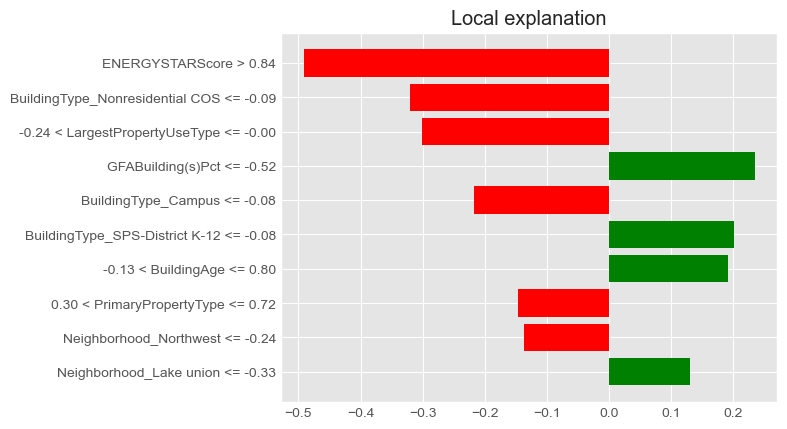

In [41]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()

Un dernier notebook sera créé et sera identique à celui-ci à l'exception que la variable cible ne sera plus l'émission en CO2 `TotalGHGEmissions` mais la consommation totale en energie `SiteEUI(kBtu/sf)` des immeubles.